## Imports

In [1]:
import numpy as np
import pocketvna
import os
import matplotlib.pyplot as plt
from stlab.devices.Vaunix_Phase import Vaunix_Phase
import time

Could not load "PocketVnaApi_x64" by systempath. Trying another one "C:\Users\Jacco\Documents\GitHub\bep-jacco-van-leenen\Code\PocketVnaApi_x64.dll"


## VNA

In [2]:
# Connecting the VNA
driver = pocketvna.Driver()

print('Driver is created: {} devices connected..'.format(driver.count()))
for i in range(0, driver.count()):
    print('Device {}'.format(i))
    print('\t {}'.format(driver.info_at(i)))

if not driver.connect_to(0):
    print('Failed to connect')

Driver is created: 1 devices connected..
Device 0
	 {'index': 0, 'path:': b'\\\\?\\hid#vid_03eb&pid_2402#7&1fc8f206&0&0000#{4d1e55b2-f16f-11cf-88cb-001111000030}', 'version': 512, 'SN': '', 'product': 'PocketVNA', 'vendor': 'Martin', 'read': True, 'write': True}


## Phase Shifters

In [3]:
# Connecting the phase shifters
ph1 = Vaunix_Phase(23869)
ph2 = Vaunix_Phase(19164)

# Setting the frequency to the minimum
ph1.SetFrequency(4200000000)
ph2.SetFrequency(4200000000)

# Setting the phase to the minimum
ph1.SetPhase(0)
ph2.SetPhase(0)

# Checking if the phases and the frequencies are set correctly
print("Phase of Phase Shifter 1: {}\nFrequency of Phase Shifter 1: {}".format(ph1.GetPhase(), ph1.GetFrequency()))
print("Phase of Phase Shifter 2: {}\nFrequency of Phase Shifter 2: {}".format(ph2.GetPhase(), ph2.GetFrequency()))

status: 0
status: 0
Phase of Phase Shifter 1: 0.0
Frequency of Phase Shifter 1: 4200000000.0
Phase of Phase Shifter 2: 0.0
Frequency of Phase Shifter 2: 4200000000.0


## Calibration Folder

In [5]:
# Setting the folder where the calibration data will be stored

# Main folder
calibration_folder_name = "Calibration_5"

# Checking if the folder exists. If it doesn't it will create the folder
if not os.path.exists(calibration_folder_name):
    os.mkdir(calibration_folder_name)

## Measurement Folder

In [4]:
# Setting the folder where the measurement data will be stored

# Main folder
measurement_folder_name = "Measurements_10"

# Checking if the folder exists. If it doesn't it will create the folder
if not os.path.exists(measurement_folder_name):
    os.mkdir(measurement_folder_name)

## Calibration data

In [6]:
# ------------------------Calibrating Single Frequency------------------------

# saving the data
def data_saving(s21, name):
    file_name ="cal-s21_{}_4_2GHz.dat".format(name)
    save_name = os.path.join("Calibration_5", file_name)
    data = np.column_stack((s21.real, s21.imag))
    np.savetxt(save_name, data)
    print("Saved: " + save_name)

#  -------------------------Setup of parameters and constants----------------------
# Start at 4_000_000_000 
freq = 4200000000
# Average amount of measurements per point
average = 20

#  -------------------------------Open Measurement---------------------------------
# Measuring
input("Open Measurement")
s11, s21, s12, s22 = driver.single_scan(freq, average, pocketvna.NetworkParams.S21)

# Saving the data
data_saving(s21, "open")

#  ------------------------------through Measurement-------------------------------
# Measuring
input("Through Measurement")
s11, s21, s12, s22 = driver.single_scan(freq, average, pocketvna.NetworkParams.S21)

# Saving the data
data_saving(s21, "through")

Open Measurement
Saved: Calibration_5\cal-s21_open_4_2GHz.dat
Through Measurement
Saved: Calibration_5\cal-s21_through_4_2GHz.dat


## Measuring

In [ ]:
#------------------------------------------Measurements--------------------------------------------

def data_saving(s21, name, start, step_size, phase_1, k):
    file_name ="{}_4_2GHz_{}-start_{}-stepsize_{}-phase_1_{}-attenuator_full.dat".format(name, start, step_size, phase_1, k)
    save_name = os.path.join("Measurements_10", file_name)
    data = np.column_stack((s21.real, s21.imag))
    np.savetxt(save_name, data)
    print("Saved: " + save_name)

def calibrating(s21):
    # Setting the file name of the calibration open calibration data
    file_name = "cal-s21_open_4_2GHz.dat"
    # Setting the path where the file can be found
    save_name = os.path.join("Calibration_5", file_name)
    # Load the data
    cal_open = np.loadtxt(save_name)
    # Get the data and put the real and imaginary part together again
    t_open = cal_open[0] + cal_open[1] * 1j
    
    # Setting the file name of the calibration open calibration data
    file_name = "cal-s21_through_4_2GHz.dat"
    # Setting the path where the file can be found
    save_name = os.path.join("Calibration_5", file_name)
    # Load the data
    cal_through = np.loadtxt(save_name)
    # Get the data and put the real and imaginary part together again
    t_through = cal_through[0] + cal_through[1] * 1j
    
    return (s21 - t_open) / (t_through - t_open)

#---------------------------------------------Setup------------------------------------------------

freq = 4200000000
average = 20
step_size = 10
start = 0
end = start + 360
phase = np.arange(start, 361, step_size)
phase_1 = np.arange(0, 360, step_size)
phase_2 = 0
ph1.SetFrequency(freq)
ph2.SetFrequency(freq)

s21 = np.zeros(len(phase), dtype=np.complex)

#------------------------------------------Measurement--------------------------------------------
for k in range(0, 20):
    input("Set the attenuator to {}".format(k))
    for j in range(len(phase_1)):

        for i in range(len(phase)):
            if (phase[i] + phase_1[j]) > 360:
                ph1.SetPhase(phase_1[j] + phase[i] - 360)
            elif (phase[i] + phase_1[j]) > 720:
                ph1.SetPhase(phase_1[j] + phase[i] - 720)
            else:
                ph1.SetPhase(phase_1[j] + phase[i])

            if (phase[i] + phase_2) > 360:
                ph2.SetPhase(phase_2 + phase[i] - 360)
            elif (phase[i] + phase_2) > 720:
                ph2.SetPhase(phase_2 + phase[i] - 720)
            else:
                ph2.SetPhase(phase_2 + phase[i])

            time.sleep(0.1)
            s11, s21[i], s12, s22 = driver.single_scan(freq, average, pocketvna.NetworkParams.S21)

        data_saving(s21, "s21-dif", start, step_size, phase_1[j], k)
        cal = calibrating(s21)
        data_saving(cal, "s21-cal-dif", start, step_size, phase_1[j], k)

Set the attenuator to 0
Saved: Measurements_10\s21-dif_4_2GHz_0-start_10-stepsize_0-phase_1_0-attenuator_full.dat
Saved: Measurements_10\s21-cal-dif_4_2GHz_0-start_10-stepsize_0-phase_1_0-attenuator_full.dat
Saved: Measurements_10\s21-dif_4_2GHz_0-start_10-stepsize_10-phase_1_0-attenuator_full.dat
Saved: Measurements_10\s21-cal-dif_4_2GHz_0-start_10-stepsize_10-phase_1_0-attenuator_full.dat
Saved: Measurements_10\s21-dif_4_2GHz_0-start_10-stepsize_20-phase_1_0-attenuator_full.dat
Saved: Measurements_10\s21-cal-dif_4_2GHz_0-start_10-stepsize_20-phase_1_0-attenuator_full.dat
Saved: Measurements_10\s21-dif_4_2GHz_0-start_10-stepsize_30-phase_1_0-attenuator_full.dat
Saved: Measurements_10\s21-cal-dif_4_2GHz_0-start_10-stepsize_30-phase_1_0-attenuator_full.dat
Saved: Measurements_10\s21-dif_4_2GHz_0-start_10-stepsize_40-phase_1_0-attenuator_full.dat
Saved: Measurements_10\s21-cal-dif_4_2GHz_0-start_10-stepsize_40-phase_1_0-attenuator_full.dat
Saved: Measurements_10\s21-dif_4_2GHz_0-start_10

Saved: Measurements_10\s21-dif_4_2GHz_0-start_10-stepsize_80-phase_1_1-attenuator_full.dat
Saved: Measurements_10\s21-cal-dif_4_2GHz_0-start_10-stepsize_80-phase_1_1-attenuator_full.dat
Saved: Measurements_10\s21-dif_4_2GHz_0-start_10-stepsize_90-phase_1_1-attenuator_full.dat
Saved: Measurements_10\s21-cal-dif_4_2GHz_0-start_10-stepsize_90-phase_1_1-attenuator_full.dat
Saved: Measurements_10\s21-dif_4_2GHz_0-start_10-stepsize_100-phase_1_1-attenuator_full.dat
Saved: Measurements_10\s21-cal-dif_4_2GHz_0-start_10-stepsize_100-phase_1_1-attenuator_full.dat
Saved: Measurements_10\s21-dif_4_2GHz_0-start_10-stepsize_110-phase_1_1-attenuator_full.dat
Saved: Measurements_10\s21-cal-dif_4_2GHz_0-start_10-stepsize_110-phase_1_1-attenuator_full.dat
Saved: Measurements_10\s21-dif_4_2GHz_0-start_10-stepsize_120-phase_1_1-attenuator_full.dat
Saved: Measurements_10\s21-cal-dif_4_2GHz_0-start_10-stepsize_120-phase_1_1-attenuator_full.dat
Saved: Measurements_10\s21-dif_4_2GHz_0-start_10-stepsize_130-ph

Saved: Measurements_10\s21-dif_4_2GHz_0-start_10-stepsize_160-phase_1_2-attenuator_full.dat
Saved: Measurements_10\s21-cal-dif_4_2GHz_0-start_10-stepsize_160-phase_1_2-attenuator_full.dat
Saved: Measurements_10\s21-dif_4_2GHz_0-start_10-stepsize_170-phase_1_2-attenuator_full.dat
Saved: Measurements_10\s21-cal-dif_4_2GHz_0-start_10-stepsize_170-phase_1_2-attenuator_full.dat
Saved: Measurements_10\s21-dif_4_2GHz_0-start_10-stepsize_180-phase_1_2-attenuator_full.dat
Saved: Measurements_10\s21-cal-dif_4_2GHz_0-start_10-stepsize_180-phase_1_2-attenuator_full.dat
Saved: Measurements_10\s21-dif_4_2GHz_0-start_10-stepsize_190-phase_1_2-attenuator_full.dat
Saved: Measurements_10\s21-cal-dif_4_2GHz_0-start_10-stepsize_190-phase_1_2-attenuator_full.dat
Saved: Measurements_10\s21-dif_4_2GHz_0-start_10-stepsize_200-phase_1_2-attenuator_full.dat
Saved: Measurements_10\s21-cal-dif_4_2GHz_0-start_10-stepsize_200-phase_1_2-attenuator_full.dat
Saved: Measurements_10\s21-dif_4_2GHz_0-start_10-stepsize_21

Saved: Measurements_10\s21-dif_4_2GHz_0-start_10-stepsize_240-phase_1_3-attenuator_full.dat
Saved: Measurements_10\s21-cal-dif_4_2GHz_0-start_10-stepsize_240-phase_1_3-attenuator_full.dat
Saved: Measurements_10\s21-dif_4_2GHz_0-start_10-stepsize_250-phase_1_3-attenuator_full.dat
Saved: Measurements_10\s21-cal-dif_4_2GHz_0-start_10-stepsize_250-phase_1_3-attenuator_full.dat
Saved: Measurements_10\s21-dif_4_2GHz_0-start_10-stepsize_260-phase_1_3-attenuator_full.dat
Saved: Measurements_10\s21-cal-dif_4_2GHz_0-start_10-stepsize_260-phase_1_3-attenuator_full.dat
Saved: Measurements_10\s21-dif_4_2GHz_0-start_10-stepsize_270-phase_1_3-attenuator_full.dat
Saved: Measurements_10\s21-cal-dif_4_2GHz_0-start_10-stepsize_270-phase_1_3-attenuator_full.dat
Saved: Measurements_10\s21-dif_4_2GHz_0-start_10-stepsize_280-phase_1_3-attenuator_full.dat
Saved: Measurements_10\s21-cal-dif_4_2GHz_0-start_10-stepsize_280-phase_1_3-attenuator_full.dat
Saved: Measurements_10\s21-dif_4_2GHz_0-start_10-stepsize_29

Saved: Measurements_10\s21-dif_4_2GHz_0-start_10-stepsize_320-phase_1_4-attenuator_full.dat
Saved: Measurements_10\s21-cal-dif_4_2GHz_0-start_10-stepsize_320-phase_1_4-attenuator_full.dat
Saved: Measurements_10\s21-dif_4_2GHz_0-start_10-stepsize_330-phase_1_4-attenuator_full.dat
Saved: Measurements_10\s21-cal-dif_4_2GHz_0-start_10-stepsize_330-phase_1_4-attenuator_full.dat
Saved: Measurements_10\s21-dif_4_2GHz_0-start_10-stepsize_340-phase_1_4-attenuator_full.dat
Saved: Measurements_10\s21-cal-dif_4_2GHz_0-start_10-stepsize_340-phase_1_4-attenuator_full.dat
Saved: Measurements_10\s21-dif_4_2GHz_0-start_10-stepsize_350-phase_1_4-attenuator_full.dat
Saved: Measurements_10\s21-cal-dif_4_2GHz_0-start_10-stepsize_350-phase_1_4-attenuator_full.dat
Set the attenuator to 5
Saved: Measurements_10\s21-dif_4_2GHz_0-start_10-stepsize_0-phase_1_5-attenuator_full.dat
Saved: Measurements_10\s21-cal-dif_4_2GHz_0-start_10-stepsize_0-phase_1_5-attenuator_full.dat
Saved: Measurements_10\s21-dif_4_2GHz_0-

Saved: Measurements_10\s21-dif_4_2GHz_0-start_10-stepsize_40-phase_1_6-attenuator_full.dat
Saved: Measurements_10\s21-cal-dif_4_2GHz_0-start_10-stepsize_40-phase_1_6-attenuator_full.dat
Saved: Measurements_10\s21-dif_4_2GHz_0-start_10-stepsize_50-phase_1_6-attenuator_full.dat
Saved: Measurements_10\s21-cal-dif_4_2GHz_0-start_10-stepsize_50-phase_1_6-attenuator_full.dat
Saved: Measurements_10\s21-dif_4_2GHz_0-start_10-stepsize_60-phase_1_6-attenuator_full.dat
Saved: Measurements_10\s21-cal-dif_4_2GHz_0-start_10-stepsize_60-phase_1_6-attenuator_full.dat
Saved: Measurements_10\s21-dif_4_2GHz_0-start_10-stepsize_70-phase_1_6-attenuator_full.dat
Saved: Measurements_10\s21-cal-dif_4_2GHz_0-start_10-stepsize_70-phase_1_6-attenuator_full.dat
Saved: Measurements_10\s21-dif_4_2GHz_0-start_10-stepsize_80-phase_1_6-attenuator_full.dat
Saved: Measurements_10\s21-cal-dif_4_2GHz_0-start_10-stepsize_80-phase_1_6-attenuator_full.dat
Saved: Measurements_10\s21-dif_4_2GHz_0-start_10-stepsize_90-phase_1_6

Saved: Measurements_10\s21-dif_4_2GHz_0-start_10-stepsize_120-phase_1_7-attenuator_full.dat
Saved: Measurements_10\s21-cal-dif_4_2GHz_0-start_10-stepsize_120-phase_1_7-attenuator_full.dat
Saved: Measurements_10\s21-dif_4_2GHz_0-start_10-stepsize_130-phase_1_7-attenuator_full.dat
Saved: Measurements_10\s21-cal-dif_4_2GHz_0-start_10-stepsize_130-phase_1_7-attenuator_full.dat
Saved: Measurements_10\s21-dif_4_2GHz_0-start_10-stepsize_140-phase_1_7-attenuator_full.dat
Saved: Measurements_10\s21-cal-dif_4_2GHz_0-start_10-stepsize_140-phase_1_7-attenuator_full.dat
Saved: Measurements_10\s21-dif_4_2GHz_0-start_10-stepsize_150-phase_1_7-attenuator_full.dat
Saved: Measurements_10\s21-cal-dif_4_2GHz_0-start_10-stepsize_150-phase_1_7-attenuator_full.dat
Saved: Measurements_10\s21-dif_4_2GHz_0-start_10-stepsize_160-phase_1_7-attenuator_full.dat
Saved: Measurements_10\s21-cal-dif_4_2GHz_0-start_10-stepsize_160-phase_1_7-attenuator_full.dat
Saved: Measurements_10\s21-dif_4_2GHz_0-start_10-stepsize_17

Saved: Measurements_10\s21-dif_4_2GHz_0-start_10-stepsize_200-phase_1_8-attenuator_full.dat
Saved: Measurements_10\s21-cal-dif_4_2GHz_0-start_10-stepsize_200-phase_1_8-attenuator_full.dat
Saved: Measurements_10\s21-dif_4_2GHz_0-start_10-stepsize_210-phase_1_8-attenuator_full.dat
Saved: Measurements_10\s21-cal-dif_4_2GHz_0-start_10-stepsize_210-phase_1_8-attenuator_full.dat
Saved: Measurements_10\s21-dif_4_2GHz_0-start_10-stepsize_220-phase_1_8-attenuator_full.dat
Saved: Measurements_10\s21-cal-dif_4_2GHz_0-start_10-stepsize_220-phase_1_8-attenuator_full.dat
Saved: Measurements_10\s21-dif_4_2GHz_0-start_10-stepsize_230-phase_1_8-attenuator_full.dat
Saved: Measurements_10\s21-cal-dif_4_2GHz_0-start_10-stepsize_230-phase_1_8-attenuator_full.dat
Saved: Measurements_10\s21-dif_4_2GHz_0-start_10-stepsize_240-phase_1_8-attenuator_full.dat
Saved: Measurements_10\s21-cal-dif_4_2GHz_0-start_10-stepsize_240-phase_1_8-attenuator_full.dat
Saved: Measurements_10\s21-dif_4_2GHz_0-start_10-stepsize_25

## Plotting

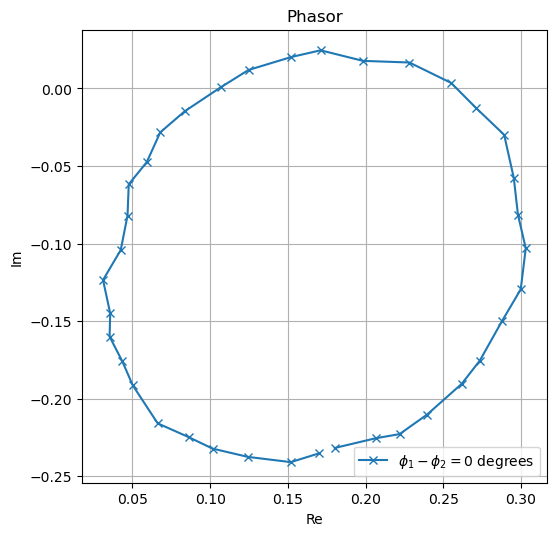

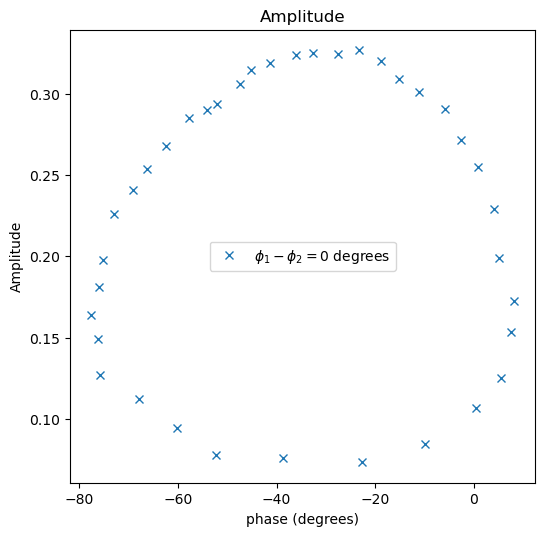

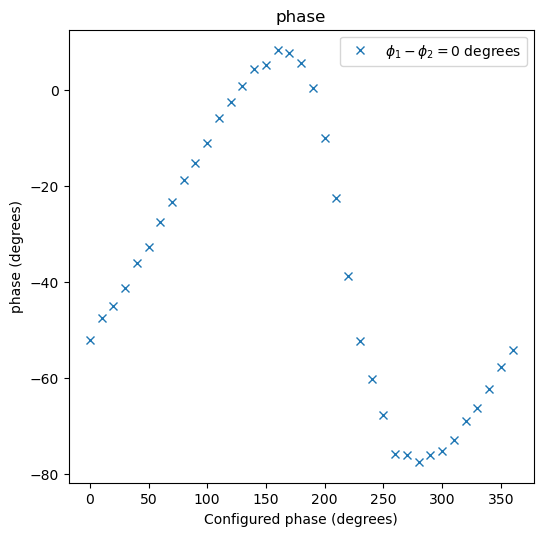

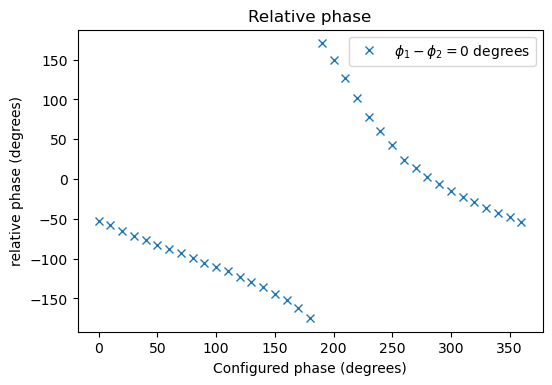

In [8]:
def opening_data(name, start, step_size, phase_1):
    # Setting the file name of the calibration open calibration data
    file_name = "{}_4_2GHz_{}-start_{}-stepsize_{}-phase_1_full.dat".format(name, start, step_size, phase_1)
    # Setting the path where the file can be found
    save_name = os.path.join("Measurements_10", file_name)
    # Load the data
    temp = np.loadtxt(save_name)
    # Get the data and put the real and imaginary part together again
    return temp[:, 0] + temp[:, 1] * 1j
    
def make_labels(phase_dif):
    temp = []
    for dif in phase_dif:
        temp.append("$\phi_1 - \phi_2 = ${} degrees".format(dif))
    return temp
    
def plot_phasor(s21, phase_dif):
    fig = plt.figure(1)
    plt.plot(s21.real, s21.imag, '-x')
    plt.xlabel("Re")
    plt.ylabel("Im")
    plt.title("Phasor")
    plt.legend(phase_dif)
    plt.grid()
    
def plot_amplitude(s21, phase_dif):
    
    amp = np.sqrt(s21.real**2 + s21.imag**2)
    phase = 180 * np.arctan2(s21.imag, s21.real)/np.pi
    
    plt.figure(2)
    plt.plot(phase, amp, 'x')
    plt.xlabel("phase (degrees)")
    plt.ylabel("Amplitude")
    plt.title("Amplitude")
    plt.legend(phase_dif)
    
def plot_phase(s21, phase, phase_dif):
    arg = 180 * np.arctan2(s21.imag, s21.real)/np.pi
    
    plt.figure(3)
    plt.plot(phase, arg, 'x')
    plt.xlabel("Configured phase (degrees)")
    plt.ylabel("phase (degrees)")
    plt.title("phase")
    plt.legend(phase_dif)
    
def plot_relative_phase(s21, phase, phase_dif, j):
    plt.rcParams['figure.figsize'] = (6,4)
    plt.rcParams['figure.dpi'] = 100
    
    arg = 180 * np.arctan2(s21.imag, s21.real)/np.pi
#     arg[arg < -180] 
    rel_phase = arg - phase
    rel_phase[rel_phase < -180] += 360
#     rel_phase[rel_phase < 0] += 360
#     rel_phase[rel_phase < j] += 360
    plt.figure(4)
    plt.plot(phase, rel_phase, 'x')
    plt.xlabel("Configured phase (degrees)")
    plt.ylabel("relative phase (degrees)")
    plt.title("Relative phase")
    plt.legend(phase_dif)
    
freq = 4200000000
average = 20
step_size = 10
start = 0
end = start + 360
phase = np.arange(start, 361, step_size)
plt.rcParams['figure.figsize'] = (6,6)
plt.rcParams['figure.dpi'] = 100

phase_dif = []
phase_difference = []
step = 0
for j in range(0 + step*10, 10+step*10, step_size):
    
    phase_difference.append(j)
    phase_dif = make_labels(phase_difference)
    
#     s21 = opening_data("s21", start, step_size, j)
    s21_cal = opening_data("s21-cal-dif", start, step_size, j)

    plot_phasor(s21_cal, phase_dif)
    plot_amplitude(s21_cal, phase_dif)
    plot_phase(s21_cal, phase, phase_dif)
    plot_relative_phase(s21_cal, phase, phase_dif, j)

(0.0, 8.0)

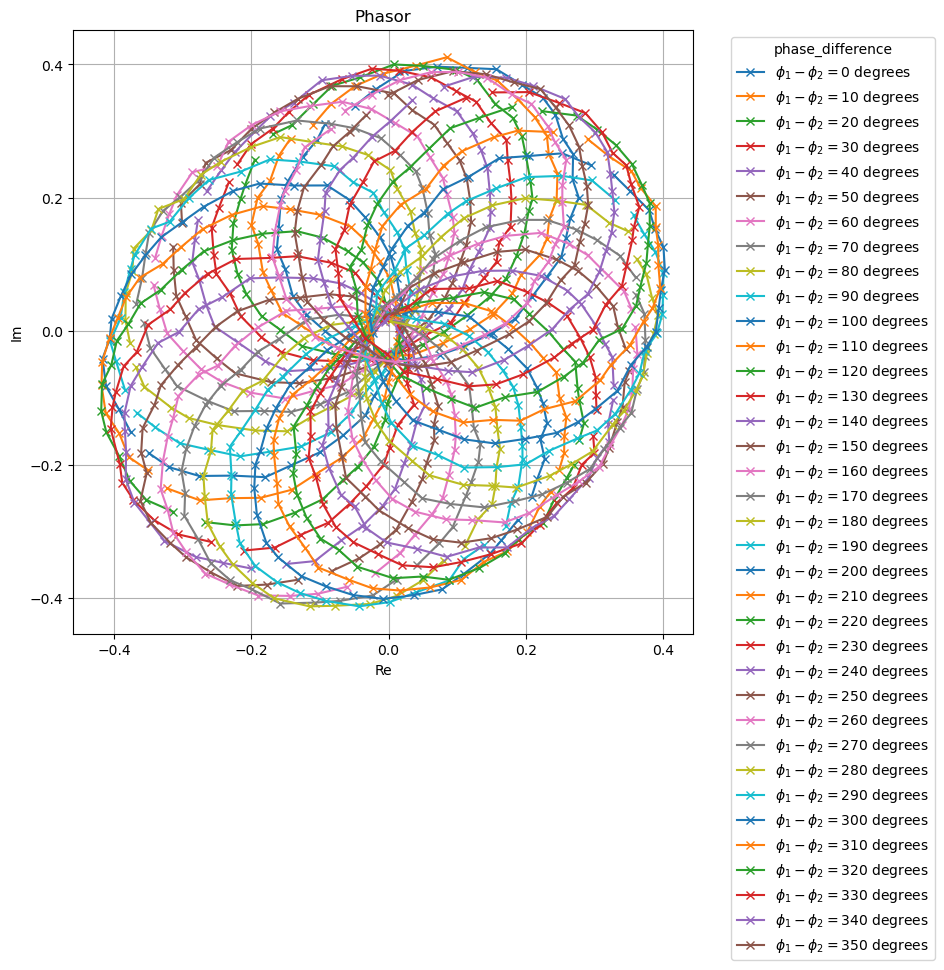

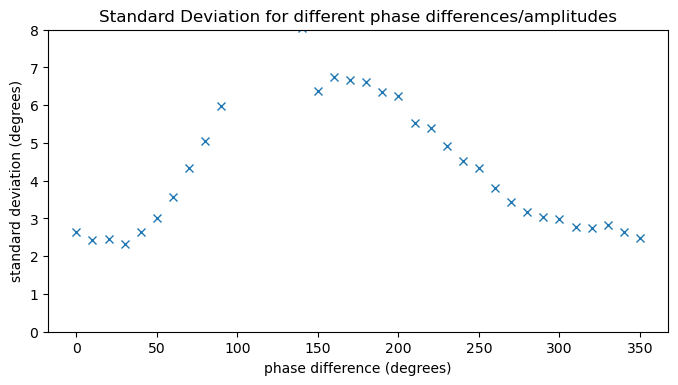

In [132]:
def opening_data(name, start, step_size, phase_1):
    # Setting the file name of the calibration open calibration data
    file_name = "{}_4_2GHz_{}-start_{}-stepsize_{}-phase_1.dat".format(name, start, step_size, phase_1)
    # Setting the path where the file can be found
    save_name = os.path.join("Measurements_5", file_name)
    # Load the data
    temp = np.loadtxt(save_name)
    # Get the data and put the real and imaginary part together again
    return temp[:, 0] + temp[:, 1] * 1j
    
def make_labels(phase_dif):
    temp = []
    for dif in phase_dif:
        temp.append("$\phi_1 - \phi_2 = ${} degrees".format(dif))
    return temp
    
def plot_phasor(s21, phase_dif):
#     fig = plt.figure(1)
    fig = plt.figure(1)
#     ax = fig.add_subplot(1, 1, 1)

#     # Move left y-axis and bottim x-axis to centre, passing through (0,0)
#     ax.spines['left'].set_position('center')
#     ax.spines['bottom'].set_position('center')

#     # Eliminate upper and right axes
#     ax.spines['right'].set_color('none')
#     ax.spines['top'].set_color('none')

#     # Show ticks in the left and lower axes only
#     ax.xaxis.set_ticks_position('bottom')
#     ax.yaxis.set_ticks_position('left')

    plt.plot(s21.real, s21.imag, '-x')
    plt.xlabel("Re")
    plt.ylabel("Im")
    plt.title("Phasor")
    plt.legend(phase_dif, title='phase_difference', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid()
    
def plot_amplitude(s21, phase_dif):
    
    amp = np.sqrt(s21.real**2 + s21.imag**2)
    phase = 180 * np.arctan2(s21.imag, s21.real)/np.pi    
    
    plt.figure(2)
    plt.plot(phase, amp, 'x')
    plt.xlabel("phase (degrees)")
    plt.ylabel("Amplitude")
    plt.title("Amplitude")
    plt.legend(phase_dif)
    
def plot_phase(s21, phase, phase_dif):
    arg = 180 * np.arctan2(s21.imag, s21.real)/np.pi
    
    plt.figure(3)
    plt.plot(phase, arg, 'x')
    plt.xlabel("phase (degrees)")
    plt.ylabel("Amplitude")
    plt.title("Amplitude")
    plt.legend(phase_dif)
    
    
freq = 4200000000
average = 20
step_size = 10
start = 0
end = start + 360
phase = np.arange(start, 361, step_size)
plt.rcParams['figure.figsize'] = (8,8)
plt.rcParams['figure.dpi'] = 100

phase_dif = []
phase_difference = []

s21_cal = np.zeros((len(phase), 36), dtype=complex)
# arg = np.zeros((len(phase), 36))
# rel_phase = np.zeros(np.shape(s21_cal))
phase_std  = np.zeros(36)

for j in range(0, 360, step_size):
    
    phase_difference.append(j)
    phase_dif = make_labels(phase_difference)
    
#     s21 = opening_data("s21", start, step_size, j)
    s21_cal[:, int(j/10)] = opening_data("s21-cal", start, step_size, j)
    
    arg = 180 * np.arctan2(s21_cal[:, int(j/10)].imag, s21_cal[:, int(j/10)].real)/np.pi
    rel_phase = arg - phase
    rel_phase[rel_phase < -180] += 360
#     rel_phase[rel_phase < 0] += 360
#     rel_phase[rel_phase < j/2] += 360

#     mean_phase = np.mean(rel_phase[:, int(j/10)])
    phase_std[int(j/10)] = np.std(rel_phase)


plot_phasor(s21_cal.transpose(), phase_dif)
# plot_amplitude(s21_cal, phase_dif)
# plot_phase(s21_cal, phase, phase_dif)

plt.rcParams['figure.figsize'] = (8,4)
plt.rcParams['figure.dpi'] = 100
plt.figure(5)
plt.plot(phase[0:-1], phase_std, 'x')
plt.xlabel("phase difference (degrees)")
plt.ylabel("standard deviation (degrees)")
plt.title("Standard Deviation for different phase differences/amplitudes")
plt.ylim([0, 8])
